In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [4]:
X.shape

(9246, 784, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [6]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=100, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(Conv1D(filters=32, kernel_size=50, activation='relu'))

cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))

            
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 685, 64)           6464      
                                                                 
 conv1d_1 (Conv1D)           (None, 636, 32)           102432    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 159, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5088)              0         
                                                                 
 dense (Dense)               (None, 100)               508900    
                                                                 
 dense_1 (Dense)             (None, 14)                1414      
                                                        

In [7]:
batch_size =300
epochs = 10
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/10
22/22 [==============================] - 25s 1s/step - loss: 1.7222 - accuracy: 0.3982 - val_loss: 1.1466 - val_accuracy: 0.6208
Epoch 2/10
22/22 [==============================] - 25s 1s/step - loss: 0.8041 - accuracy: 0.7466 - val_loss: 0.4991 - val_accuracy: 0.8713
Epoch 3/10
22/22 [==============================] - 24s 1s/step - loss: 0.3017 - accuracy: 0.9121 - val_loss: 0.2518 - val_accuracy: 0.9128
Epoch 4/10
22/22 [==============================] - 25s 1s/step - loss: 0.3176 - accuracy: 0.9093 - val_loss: 0.2400 - val_accuracy: 0.9326
Epoch 5/10
22/22 [==============================] - 24s 1s/step - loss: 0.1143 - accuracy: 0.9589 - val_loss: 0.0791 - val_accuracy: 0.9769
Epoch 6/10
22/22 [==============================] - 25s 1s/step - loss: 0.0554 - accuracy: 0.9845 - val_loss: 0.0369 - val_accuracy: 0.9921
Epoch 7/10
22/22 [==============================] - 26s 1s/step - loss: 0.0247 - accuracy: 0.9955 - val_loss: 0.0286 - val_accuracy: 0.9935
Epoch 8/10
22/22 [==

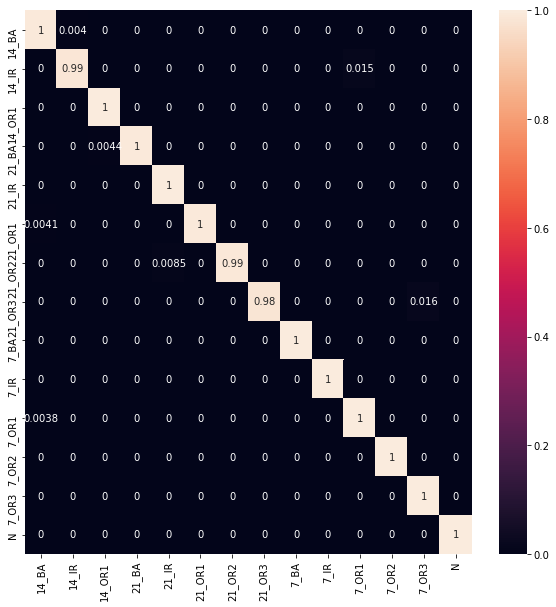

In [8]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [9]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

In [10]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.020s...
[t-SNE] Computed neighbors for 6472 samples in 0.334s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 0.000000


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')